<a href="https://colab.research.google.com/github/umairiqbal78/Deep-learning-examples/blob/master/using_pretrained_model_beautiful_vs_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/beautiful_and_average_dataset/beautiful_and_average_datasetmodel_beautiful_vs_avg1.h5")  

In [ ]:
train_dir = "/content/drive/My Drive/beautiful_and_average_dataset/train"
val_dir = "/content/drive/My Drive/beautiful_and_average_dataset/valid"
test_dir = "/content/drive/My Drive/beautiful_and_average_dataset/test"

In [ ]:
validation_beautiful_dir = "/content/drive/My Drive/beautiful_and_average_dataset/valid/beautiful"
validation_average_dir = "/content/drive/My Drive/beautiful_and_average_dataset/valid/average"

In [ ]:
train_beautiful_dir = "/content/drive/My Drive/beautiful_and_average_dataset/train/beautiful"
train_average_dir = "/content/drive/My Drive/beautiful_and_average_dataset/train/average"

In [ ]:
test_beautiful_dir = "/content/drive/My Drive/beautiful_and_average_dataset/test/beautiful"
test_average_dir = "/content/drive/My Drive/beautiful_and_average_dataset/test/average"

In [ ]:
print('total validation_beautiful_images:', len(os.listdir(validation_beautiful_dir)))
print('total validation_average_images:', len(os.listdir(validation_average_dir)))
print('total  train_beautiful_images:', len(os.listdir(train_beautiful_dir)))
print('total train_average_images:', len(os.listdir(train_average_dir)))
print('total test_beautiful_images:', len(os.listdir(test_beautiful_dir)))
print('total test_average_images:', len(os.listdir(test_beautiful_dir)))


total validation_beautiful_images: 150
total validation_average_images: 150
total  train_beautiful_images: 2000
total train_average_images: 2000
total test_beautiful_images: 150
total test_average_images: 150


In [ ]:
# 5.3 Using a pretrained convnet
#Instantiating the VGG16 convolutional base
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
#FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION
#Extracting features using the pretrained convolutional base
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary')
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(val_dir, 300)
test_features, test_labels = extract_features(test_dir, 300)

Found 4000 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (300, 4*4* 512))
test_features = np.reshape(test_features, (300, 4*4* 512))

In [ ]:
#Listing 5.18 Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

NameError: ignored

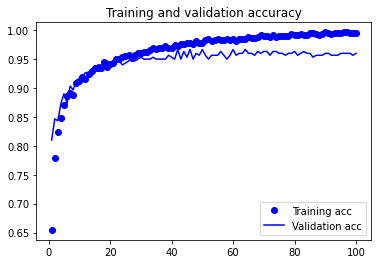

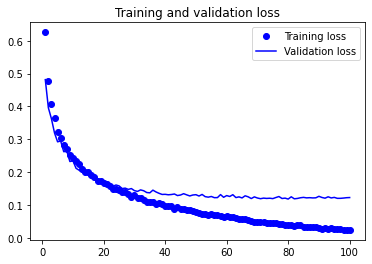

In [ ]:
#Listing 5.19 Plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
import pickle

modelStoragePath = "/content/drive/My Drive/beautiful_and_average_dataset/"

def saveData(model, history, iteration):
    modelFile = modelStoragePath + "pretrianed_model_beautiful_vs_avg" + str(iteration).strip() + ".h5"
    historyFile = modelStoragePath + "pretrained_History_beautiful_vs_avg" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving history file too
    with open(historyFile, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return modelFile, historyFile

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "pretrianed_model_beautiful_vs_avg" + str(iteration).strip() + ".h5"
    historyFile = modelStoragePath + "pretrained_History_beautiful_vs_avg" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(historyFile, 'rb') as file_pi:
        history = pickle.load(file_pi)
    return model, history

In [ ]:
print(type(history))
modelFile, HistoryFile = saveData(model, history, iteration=1)
print(modelFile, HistoryFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/My Drive/beautiful_and_average_dataset/pretrianed_model_beautiful_vs_avg1.h5 /content/drive/My Drive/beautiful_and_average_dataset/pretrained_History_beautiful_vs_avg1.pkle Saved


In [ ]:
#FEATURE EXTRACTION WITH DATA AUGMENTATION
#Listing 5.20 Adding a densely connected classifier on top of the convolutional base
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Fine tuning of pre-trained model

In [ ]:
#Listing 5.22 Freezing all layers up to a specific one
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
#Listing 5.21 Training the model end to end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=3,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=int(2000/40),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=int(300/15))

Found 4000 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/30
50/50 [==============================] - 227s 5s/step - loss: 0.3720 - acc: 0.8350 - val_loss: 0.2326 - val_acc: 0.9133
Epoch 2/30
50/50 [==============================] - 232s 5s/step - loss: 0.2958 - acc: 0.8770 - val_loss: 0.5284 - val_acc: 0.7700
Epoch 3/30
50/50 [==============================] - 228s 5s/step - loss: 0.3309 - acc: 0.8520 - val_loss: 0.1661 - val_acc: 0.9567
Epoch 4/30
50/50 [==============================] - 228s 5s/step - loss: 0.2979 - acc: 0.8800 - val_loss: 0.2071 - val_acc: 0.9167
Epoch 5/30
50/50 [==============================] - 232s 5s/step - loss: 0.2550 - acc: 0.8960 - val_loss: 0.3077 - val_acc: 0.8533
Epoch 6/30
50/50 [==============================] - 226s 5s/step - loss: 0.2589 - acc: 0.8920 - val_loss: 0.3710 - val_acc: 0.8400
Epoch 7/30
50/50 [==============================] - 226s 5s/step - loss: 0.2430 - acc: 0.9020 - val_loss: 0.1898 - val_acc: 0.9233


In [ ]:
import pickle

modelStoragePath = "/content/drive/My Drive/beautiful_and_average_dataset/"

def saveData(model, history, iteration):
    modelFile = modelStoragePath + "final_pretrianed_model_beautiful_vs_avg" + str(iteration).strip() + ".h5"
    historyFile = modelStoragePath + "final_pretrained_History_beautiful_vs_avg" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving history file too
    with open(historyFile, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return modelFile, historyFile

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "final_pretrianed_model_beautiful_vs_avg" + str(iteration).strip() + ".h5"
    historyFile = modelStoragePath + "final_pretrained_History_beautiful_vs_avg" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(historyFile, 'rb') as file_pi:
        history = pickle.load(file_pi)
    return model, history

In [ ]:
print(type(history))
modelFile, HistoryFile = saveData(model, history, iteration=1)
print(modelFile, HistoryFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/My Drive/beautiful_and_average_dataset/final_pretrianed_model_beautiful_vs_avg1.h5 /content/drive/My Drive/beautiful_and_average_dataset/final_pretrained_History_beautiful_vs_avg1.pkle Saved


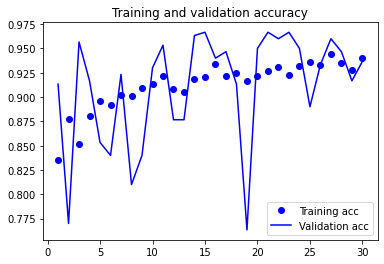

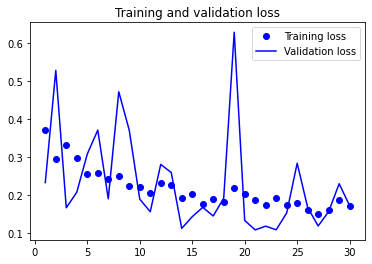

# Steps per epochs and different hyper-parameters are changed

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
#Listing 5.21 Training the model end to end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=int(2000/20),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=int(300/10))

Found 4000 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 602s 6s/step - loss: 0.5204 - acc: 0.7470 - val_loss: 0.3694 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 589s 6s/step - loss: 0.3785 - acc: 0.8435 - val_loss: 0.3677 - val_acc: 0.8267
Epoch 3/30
100/100 [==============================] - 589s 6s/step - loss: 0.3067 - acc: 0.8700 - val_loss: 0.1911 - val_acc: 0.9500
Epoch 4/30
100/100 [==============================] - 588s 6s/step - loss: 0.2980 - acc: 0.8770 - val_loss: 0.1839 - val_acc: 0.9433
Epoch 5/30
100/100 [==============================] - 588s 6s/step - loss: 0.2636 - acc: 0.8895 - val_loss: 0.1609 - val_acc: 0.9567
Epoch 6/30
100/100 [==============================] - 592s 6s/step - loss: 0.2610 - acc: 0.8950 - val_loss: 0.2227 - val_acc: 0.9067
Epoch 7/30
100/100 [==============================] - 588s 6s/step - loss: 0.2477 - acc: 0.9120 - val_loss: 0.2237 - va

In [ ]:
import pickle

modelStoragePath = "/content/drive/My Drive/beautiful_and_average_dataset/"

def saveData(model, history, iteration):
    modelFile = modelStoragePath + "upgdated_pretrianed_model_beautiful_vs_avg" + str(iteration).strip() + ".h5"
    historyFile = modelStoragePath + "updated_pretrained_History_beautiful_vs_avg" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving history file too
    with open(historyFile, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return modelFile, historyFile

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "upgdated_pretrianed_model_beautiful_vs_avg" + str(iteration).strip() + ".h5"
    historyFile = modelStoragePath + "updated_pretrained_History_beautiful_vs_avg" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(historyFile, 'rb') as file_pi:
        history = pickle.load(file_pi)
    return model, history

In [ ]:
print(type(history))
modelFile, HistoryFile = saveData(model, history, iteration=1)
print(modelFile, HistoryFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/My Drive/beautiful_and_average_dataset/upgdated_pretrianed_model_beautiful_vs_avg1.h5 /content/drive/My Drive/beautiful_and_average_dataset/updated_pretrained_History_beautiful_vs_avg1.pkle Saved


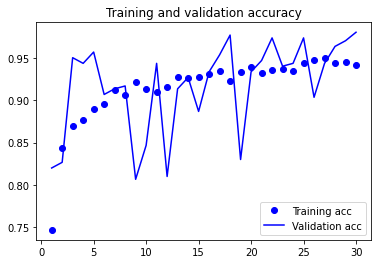

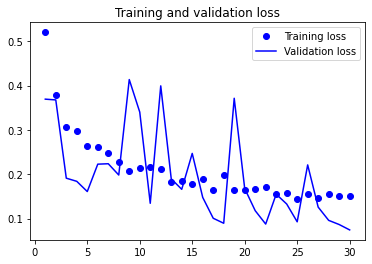

In [ ]:
#Listing 5.19 Plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()